In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import mlxtend.classifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [2]:
training_text = pd.read_csv('training_text', sep = "\|\|", engine='python',
                           names = ['ID', 'TEXT'], skiprows = 1)
training_variants = pd.read_csv('training_variants')
temp_training_variants = pd.read_csv('training_variants')

In [3]:
training_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
print('No of points in data: ', training_text.shape[0])
print('No of features: ', training_text.shape[1])
print("Name of features: ", training_text.columns.values)

No of points in data:  3321
No of features:  2
Name of features:  ['ID' 'TEXT']


In [5]:
print('No of points in data: ', training_variants.shape[0])
print('No of features: ', training_variants.shape[1])
print("Name of features: ", training_variants.columns.values)

No of points in data:  3321
No of features:  4
Name of features:  ['ID' 'Gene' 'Variation' 'Class']


In [6]:
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [7]:
import nltk
#nltk.download()
from nltk.corpus import stopwords
# loading stopwords

stop_words = set(stopwords.words('english'))

In [8]:
import re
def nlp_prepocesssing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        
        #replace every specail character with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        
        #replace multple spaces with single space
        total_text = re.sub('\s+', ' ', total_text)
        
        #convert all char in lower case
        total_text = total_text.lower()
        
        for word in total_text.split():
            #word is not in stopword then store it
            if not word in stop_words:
                string += word + " "
                
        training_text[column][index] = string

In [9]:
import time
start_time = time.perf_counter() 
  
for index, row in training_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_prepocesssing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id: ", index)
print("Time took for preproceesing = ", time.perf_counter() -start_time, 'seconds')

There is no text description for id:  1109
There is no text description for id:  1277
There is no text description for id:  1407
There is no text description for id:  1639
There is no text description for id:  2755
Time took for preproceesing =  83.05598120000002 seconds


In [10]:
df_data = pd.merge(training_variants,training_text, how = 'left')
df_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
df_data.isnull().any()

ID           False
Gene         False
Variation    False
Class        False
TEXT          True
dtype: bool

In [12]:
print("No of null values in TEXT data are :" , df_data['TEXT'].isnull().sum())

No of null values in TEXT data are : 5


In [13]:
df_data[df_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [14]:
df_data.loc[df_data['TEXT'].isnull(), 'TEXT'] = df_data['Gene'] + ' ' + df_data['Variation']

In [15]:
print("No of null values in TEXT data are :" , df_data['TEXT'].isnull().sum())
df_data[df_data['ID'] == 1277]

No of null values in TEXT data are : 0


,ID,Gene,Variation,Class,TEXT
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations


In [16]:
print("No of null values in TEXT data are :" , df_data['TEXT'].isnull().sum())
df_data[df_data['ID'] == 1276]

No of null values in TEXT data are : 0


,ID,Gene,Variation,Class,TEXT
1276,1276,PIK3R2,S273C,5,demonstrate phosphatidylinositol 3 kinase pi3k...


In [17]:
test_text = pd.read_csv('test_text', sep = "\|\|", engine='python',
                           names = ['ID', 'TEXT'], skiprows = 1)
test_variants = pd.read_csv('test_variants')

In [18]:
test_text.head()

,ID,TEXT
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [19]:
print('No of points in data: ', test_text.shape[0])
print('No of features: ', test_text.shape[1])
print("Name of features: ", test_text.columns.values)

No of points in data:  5668
No of features:  2
Name of features:  ['ID' 'TEXT']


In [20]:
import re
def nlp_prepocesssing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        
        #replace every specail character with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        
        #replace multple spaces with single space
        total_text = re.sub('\s+', ' ', total_text)
        
        #convert all char in lower case
        total_text = total_text.lower()
        
        for word in total_text.split():
            #word is not in stopword then store it
            if not word in stop_words:
                string += word + " "
                
        test_text[column][index] = string

In [21]:
import time
start_time = time.perf_counter() 
  
for index, row in test_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_prepocesssing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id: ", index)
print("Time took for preproceesing = ", time.perf_counter() -start_time, 'seconds')

There is no text description for id:  1623
Time took for preproceesing =  403.5206297 seconds


In [22]:
df_test = pd.merge(test_variants,test_text, how = 'left')
df_test.head()

,ID,Gene,Variation,TEXT
0,0,ACSL4,R570S,2 mutation resulted myeloproliferative phenoty...
1,1,NAGLU,P521L,abstract large tumor suppressor 1 lats1 serine...
2,2,PAH,L333F,vascular endothelial growth factor receptor ve...
3,3,ING1,A148D,inflammatory myofibroblastic tumor imt neoplas...
4,4,TMEM216,G77A,abstract retinoblastoma pediatric retinal tumo...


In [23]:
df_test[df_test.isnull().any(axis=1)]

,ID,Gene,Variation,TEXT
1623,1623,AURKB,Amplification,NaN


In [24]:
df_test.dropna(subset=['TEXT'], inplace=True)
df_test.isnull().any()

ID           False
Gene         False
Variation    False
TEXT         False
dtype: bool

In [25]:
merged_df = pd.merge(df_data, df_test, 
                     on=['ID','Gene', 'Variation','TEXT'], how='outer')

In [26]:
merged_df[merged_df.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
3321,0,ACSL4,R570S,NaN,2 mutation resulted myeloproliferative phenoty...
3322,1,NAGLU,P521L,NaN,abstract large tumor suppressor 1 lats1 serine...
3323,2,PAH,L333F,NaN,vascular endothelial growth factor receptor ve...
3324,3,ING1,A148D,NaN,inflammatory myofibroblastic tumor imt neoplas...
3325,4,TMEM216,G77A,NaN,abstract retinoblastoma pediatric retinal tumo...
...,...,...,...,...,...
8983,5663,SLC46A1,R113S,NaN,realization late 1970s ras harboured transform...
8984,5664,FOXC1,L130F,NaN,hemizygous deletions common molecular abnormal...
8985,5665,GSS,R267W,NaN,r267w smartpool investigate 533 experiments 5q...
8986,5666,CTSK,G79E,NaN,abstract blood samples 125 unrelated families ...


In [27]:
merged_df.isnull().any()

ID           False
Gene         False
Variation    False
Class         True
TEXT         False
dtype: bool

In [28]:
print(merged_df['Class'].isnull().sum())

5667


In [29]:
class_number = pd.read_csv('stage1_solution_filtered.csv')


In [30]:
class_number.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,12,1,0,0,0,0,0,0,0,0
1,19,0,1,0,0,0,0,0,0,0
2,21,0,1,0,0,0,0,0,0,0
3,55,0,0,0,1,0,0,0,0,0
4,64,0,0,0,1,0,0,0,0,0


In [31]:
one_hot_columns = ['class1','class2','class3','class4','class5','class6','class7','class8','class9']

In [32]:
#decoding
class_number['Class']=class_number[one_hot_columns].idxmax(axis=1)

In [33]:
category_mapping={'class1':1,'class2':2,'class3':3,'class4':4,'class5':5,'class6':6,'class7':7,'class8':8,'class9':9}

In [34]:
#format to numeric
class_number['Class']=class_number['Class'].map(category_mapping)

In [35]:
class_number.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9,Class
0,12,1,0,0,0,0,0,0,0,0,1
1,19,0,1,0,0,0,0,0,0,0,2
2,21,0,1,0,0,0,0,0,0,0,2
3,55,0,0,0,1,0,0,0,0,0,4
4,64,0,0,0,1,0,0,0,0,0,4


In [36]:
drop_colunms=['class1','class2','class3','class4','class5','class6','class7','class8','class9']

In [37]:
class_number=class_number.drop(columns=drop_colunms)

In [38]:
class_number.head()

,ID,Class
0,12,1
1,19,2
2,21,2
3,55,4
4,64,4


In [39]:
print('No of points in data: ', class_number.shape[0])
print('No of features: ', class_number.shape[1])
print("Name of features: ", class_number.columns.values)

No of points in data:  368
No of features:  2
Name of features:  ['ID' 'Class']


In [40]:
class_number['Gene'] = np.nan
class_number['Variation'] = np.nan
class_number['TEXT'] = np.nan

# Step 3: Write the DataFrame back to the CSV file
class_number.to_csv('updated_class_number.csv', index=False)

In [41]:
updatedClassNumber = pd.read_csv('updated_class_number.csv')

In [42]:
updatedClassNumber.head()

,ID,Class,Gene,Variation,TEXT
0,12,1,NaN,NaN,NaN
1,19,2,NaN,NaN,NaN
2,21,2,NaN,NaN,NaN
3,55,4,NaN,NaN,NaN
4,64,4,NaN,NaN,NaN


In [43]:
print(updatedClassNumber[['Gene', 'Variation', 'TEXT']].isnull().sum())

Gene         368
Variation    368
TEXT         368
dtype: int64


In [44]:
updatedClassNumber['Gene'] = updatedClassNumber['Gene'].fillna('')
updatedClassNumber['Variation'] = updatedClassNumber['Variation'].fillna('')
updatedClassNumber['TEXT'] = updatedClassNumber['TEXT'].fillna('')

In [45]:
updatedClassNumber['Gene'] = updatedClassNumber['Gene'].astype(str)
updatedClassNumber['Variation'] = updatedClassNumber['Variation'].astype(str)
updatedClassNumber['TEXT'] = updatedClassNumber['TEXT'].astype(str)

In [46]:
final_data = pd.merge(merged_df, updatedClassNumber, 
                     on=['ID','Class','Gene','Variation','TEXT'], how='outer')

In [47]:
final_data['Class'] = final_data['Class'].replace('nan', pd.NA)

# Convert 'Class' column to numeric data type
final_data['Class'] = pd.to_numeric(final_data['Class'], errors='coerce')

# Convert 'Class' column to integers
final_data['Class'] = final_data['Class'].astype('Int64')

# Drop rows with NaN values in the 'Class' column
# final_data.dropna(subset=['Class'], inplace=True)

In [48]:
final_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [49]:
median_class = final_data['Class'].mode()
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=1)
final_data['Class'] = imputer.fit_transform(final_data[['Class']]).ravel()

In [50]:
print(final_data[['Class']].isnull().sum())

Class    0
dtype: int64


In [51]:
final_data.isnull().any()

ID           False
Gene         False
Variation    False
Class        False
TEXT         False
dtype: bool

In [52]:
print('No of points in data: ', final_data.shape[0])
print('No of features: ', final_data.shape[1])
print("Name of features: ", final_data.columns.values)

No of points in data:  9356
No of features:  5
Name of features:  ['ID' 'Gene' 'Variation' 'Class' 'TEXT']


In [53]:
import pandas as pd

# Assuming your target variable is in a DataFrame column named 'count'
final_data['Class'] = final_data['Class'].round().astype(int)

bins = [-float('inf'), 1, 2, 3, 4, 5, 6, 7, 8, 9, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
final_data['Class'] = pd.cut(final_data['Class'], bins=bins, labels=labels, include_lowest=True, right=False).astype(int)


In [54]:
print(final_data['Class'].dtype)
print(final_data['Class'].head())

int32
0    2
1    3
2    3
3    4
4    5
Name: Class, dtype: int32


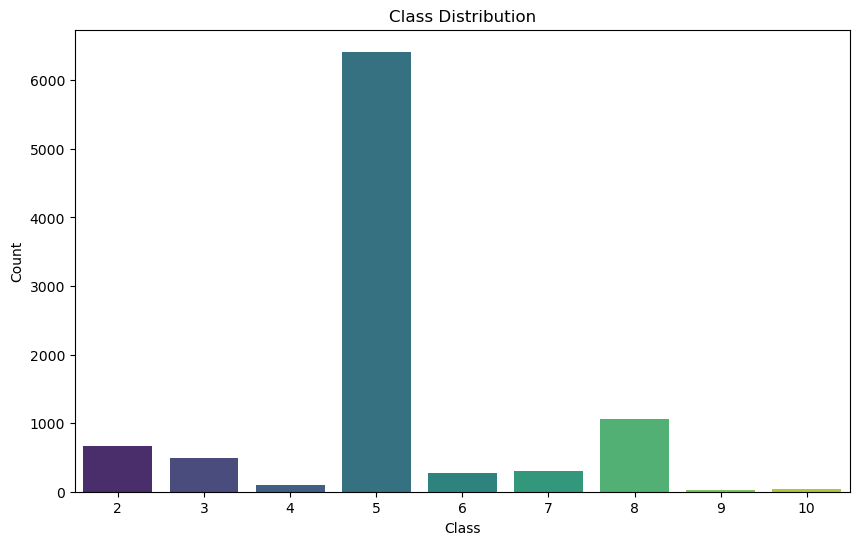

Class Distribution:
5     6418
8     1054
2      662
3      498
7      297
6      267
4       96
10      43
9       21
Name: Class, dtype: int64


In [55]:
# Assuming 'final_data' is your DataFrame
class_distribution = final_data['Class'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print("Class Distribution:")
print(class_distribution)

In [56]:
X = final_data.drop(columns=['Class'])
y = final_data['Class']

In [57]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
df_data.gene = df_data.Gene.str.replace('\s+', '_')
df_data.variation = df_data.Variation.str.replace('\s+', '_')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
# unvariant analysis
# gene
unique_genes = X_train['Gene'].value_counts()
print("Number of unique values: ", unique_genes.shape[0])
print(unique_genes.head())

Number of unique values:  1331
         248
BRCA1    209
TP53     124
EGFR     111
F8       100
Name: Gene, dtype: int64


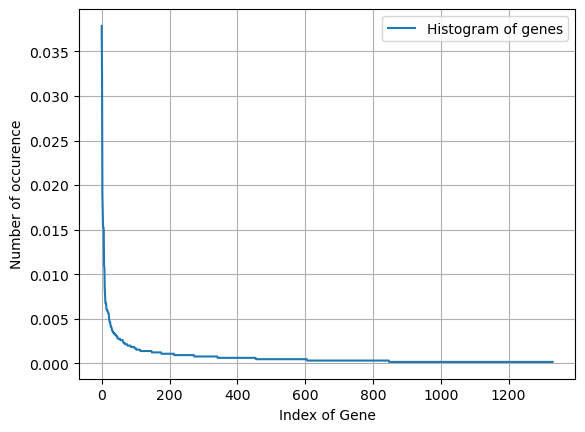

In [59]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label = "Histogram of genes")
plt.xlabel("Index of Gene")
plt.ylabel("Number of occurence")
plt.legend()
plt.grid()
plt.show()

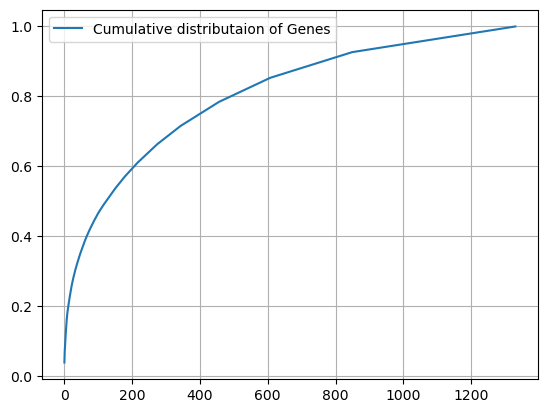

In [60]:
c= np.cumsum(h)
plt.plot(c, label = 'Cumulative distributaion of Genes')
plt.grid()
plt.legend()
plt.show()

In [61]:
# #one hot encoding of gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])

X_train['Gene'].head()

8063    MED13L
5314       ARX
3181      AKT3
4950      TP53
1755      IDH1
Name: Gene, dtype: object

In [62]:
import joblib
joblib.dump(train_gene_feature_onehotCoding, 'geneVectorizer.pkl')

['geneVectorizer.pkl']

In [63]:
len(gene_vectorizer. get_feature_names_out() )

1327

In [64]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", 
                                              train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (6549, 1327)


In [65]:
# variation feature
unique_variations = X_train['Variation'].value_counts()
print("Number of unique Variation: ", unique_variations.shape[0])

Number of unique Variation:  6059


In [66]:
unique_variations.head()

                        248
Truncating Mutations     74
Deletion                 57
Amplification            56
Fusions                  24
Name: Variation, dtype: int64

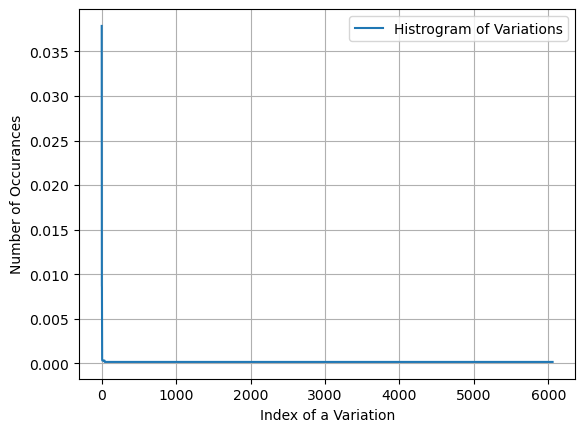

In [67]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.03786838 0.04916781 0.05787143 ... 0.99969461 0.9998473  1.        ]


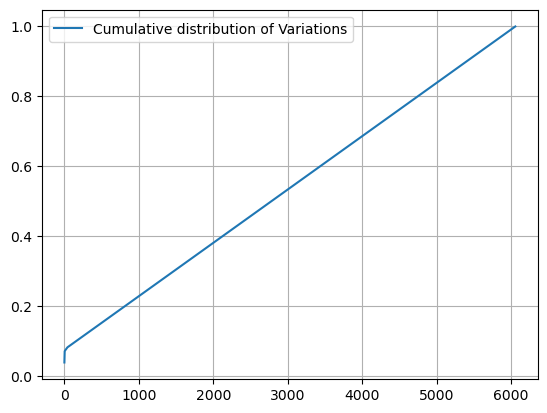

In [68]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [69]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])

print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:",
      train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (6549, 6091)


In [70]:
import joblib
joblib.dump(train_variation_feature_onehotCoding, 'variationVectorizer.pkl')

['variationVectorizer.pkl']

In [71]:
#on text feature
import collections
def extract_dictionary_paddle(cls_text):
    dictionary = collections.defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [72]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 133169


In [73]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text =final_data[final_data['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(df_data)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [74]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))
print(Counter(sorted_text_occur))

Counter({3: 16774, 4: 16279, 5: 13140, 6: 8917, 7: 5784, 8: 4769, 9: 3973, 10: 3332, 11: 2755, 12: 2710, 13: 2486, 14: 1933, 15: 1774, 16: 1642, 17: 1438, 18: 1327, 19: 1212, 20: 1134, 22: 1121, 21: 1121, 24: 875, 23: 869, 26: 825, 25: 785, 27: 721, 28: 694, 30: 626, 29: 609, 31: 577, 33: 555, 32: 537, 35: 467, 34: 454, 36: 451, 47: 440, 38: 409, 39: 392, 37: 379, 41: 358, 42: 350, 40: 349, 46: 340, 44: 337, 43: 330, 48: 311, 45: 298, 51: 288, 49: 277, 50: 270, 52: 248, 53: 246, 54: 240, 58: 236, 55: 236, 68: 233, 56: 229, 62: 228, 67: 224, 60: 220, 57: 219, 61: 201, 69: 187, 64: 184, 66: 182, 65: 181, 63: 181, 59: 179, 74: 177, 73: 165, 71: 150, 78: 149, 70: 149, 76: 148, 75: 148, 72: 146, 84: 143, 81: 143, 77: 143, 80: 137, 79: 137, 93: 132, 85: 132, 91: 129, 86: 126, 82: 123, 87: 122, 95: 121, 88: 121, 83: 120, 98: 119, 94: 119, 90: 117, 104: 113, 89: 113, 92: 109, 103: 103, 99: 100, 97: 100, 102: 97, 105: 95, 101: 93, 107: 91, 112: 90, 106: 89, 113: 88, 116: 85, 100: 85, 130: 84, 1

In [75]:
import joblib
joblib.dump(train_text_feature_onehotCoding, 'textVectorizer.pkl')

['textVectorizer.pkl']

In [76]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))


train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
y_tarin = np.array(list(df_data['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()



print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (6549, 140587)
(number of data points * number of features) in test data =  (2807, 140587)


In [77]:
###### over sampling with SMOTE######
sm = SMOTE()
train_x_onehotCoding_smt,y_train_smt=sm.fit_resample(train_x_onehotCoding,y_train)

In [78]:
import pickle

In [ ]:
# Initialize SVM model
svm_model = SVC()  

# Train the SVM model
svm_model.fit(train_x_onehotCoding_smt,y_train_smt)

# Predictions on training data
train_predictions = svm_model.predict(train_x_onehotCoding_smt)

# Predictions on test data
test_predictions = svm_model.predict(test_x_onehotCoding)

# Accuracy on training data
train_accuracy = accuracy_score(y_train_smt, train_predictions)
print("Training Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, test_predictions)
print("Training Accuracy:", train_accuracy)
                                             
# true_test= pd.read_csv("stage1_solution_filtered.csv")
# test_log_loss = log_loss(true_test, test_predictions)
# print("Log Loss on Test Data:", test_log_loss)

In [ ]:
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)

In [ ]:
pickle.dump(svm_model, open('model.pkl', 'wb'))

In [88]:
import joblib
import scipy.sparse

def predict_class(gene_vectorized, variation_vectorized, text_vectorized):
    # Combine the vectorized representations if necessary (e.g., concatenate them)
    combined_features = scipy.sparse.hstack([gene_vectorized, variation_vectorized, text_vectorized])

    # Make predictions
    prediction = model.predict(combined_features)
    return prediction[0]

def main():
    # Get input from the user
    gene = input("Enter gene: ")
    variation = input("Enter variation: ")
    text = input("Enter text: ")

    # Predict the class
    predicted_class = predict_class(gene_vectorizer, variation_vectorizer, text_vectorizer)

    # Print the predicted class
    print("Predicted class:", predicted_class)

if __name__ == "__main__":
    gene_vectorizer = joblib.load('geneVectorizer.pkl')
    variation_vectorizer = joblib.load('variationVectorizer.pkl')
    text_vectorizer = joblib.load('textVectorizer.pkl')
    model = joblib.load('model.pkl')  # Replace 'model.pkl' with the filename of your trained model
    main()

Enter gene: FAM58A
Enter variation: Truncating Mutations
Enter text: Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants ar

Predicted class: 5
